# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 69135.29 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 97977.46 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 112152.88 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 122517.56 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 130256.76 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 141585.38 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 73212.64 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 102823.24 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 127511.63 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 133716.03 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 146715.94 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.25 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.46 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.25 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.64 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.48 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.41 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.07 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.95 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.41 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.48 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.20 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.66 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.33 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.63 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.11 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.99 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.17 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.10 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.44 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.29 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.90 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.12 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 41.87 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 45.55 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 48.47 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 48.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.24 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.27 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.58 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 26.99 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 33.73 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.88 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.81 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.49 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.05 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 43.49 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.26 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 44.48 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.57 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.65 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.54 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.59 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.66 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.75 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.66 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.36 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.69 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.56 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.55 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.41 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.84 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.43 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.05 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.37 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.33 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 47.77 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.19 examples/s]

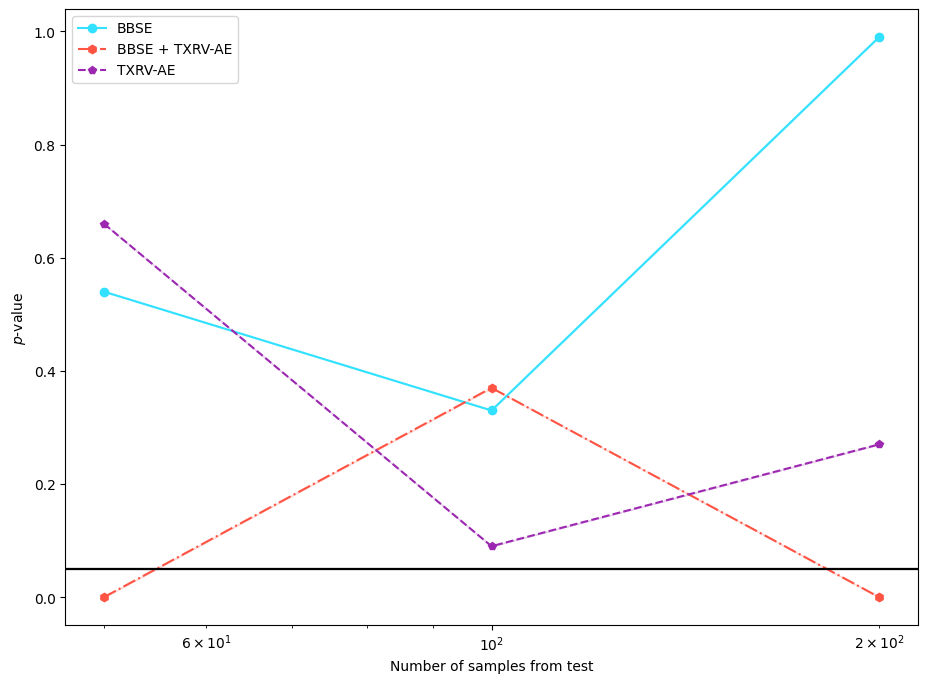

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.81 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.60 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.79 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.23 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.36 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.24 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.13 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.05 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.56 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.67 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 37.23 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.31 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.62 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.62 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.49 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.15 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.34 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.17 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.82 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.82 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.13 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.58 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.24 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.85 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.92 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.94 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.51 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.24 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.41 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.74 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.09 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.39 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.79 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.71 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.80 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.47 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.86 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.04 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.93 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.63 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.61 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.11 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.54 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.63 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.30 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.75 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.82 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.88 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.22 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.23 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.26 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.97 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.81 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.88 examples/s]

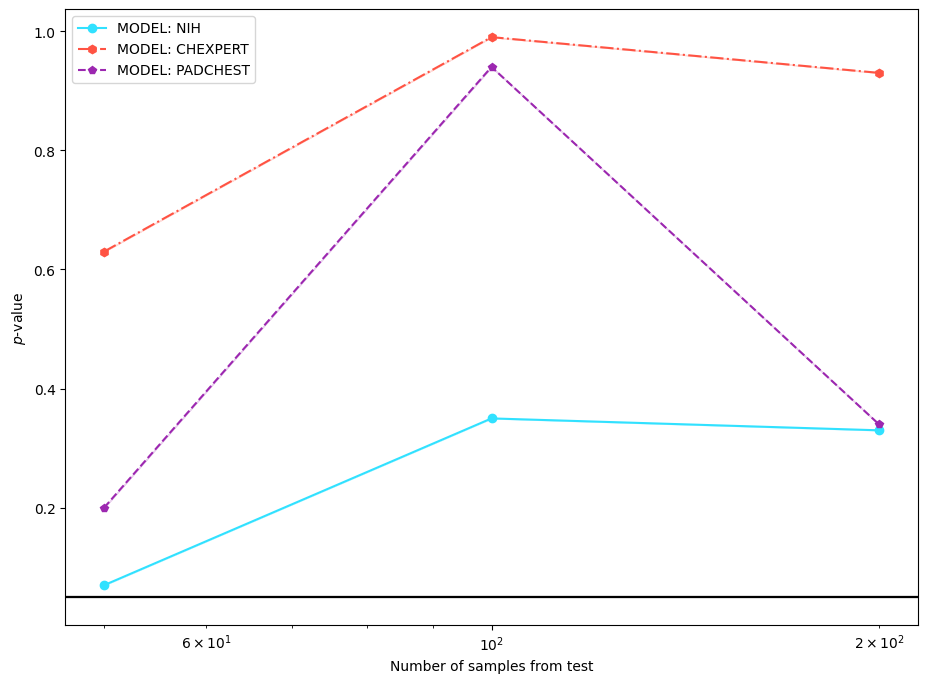

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56971.02 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 82647.95 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 96097.86 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 103159.60 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 107815.12 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108976.74 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55157.88 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81403.72 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 95210.03 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100190.82 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 111653.93 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 114841.93 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.70 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.58 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.22 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.92 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.03 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.77 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.25 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.13 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.32 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.68 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.39 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.11 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.11 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.02 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.60 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.98 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.08 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.08 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53334.11 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 74817.94 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93014.42 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100970.35 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103690.64 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106900.38 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51274.43 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 70493.74 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90499.21 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97658.39 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 107106.75 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 113179.80 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.87 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.94 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.53 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.51 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.72 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.50 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.18 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.15 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.82 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.50 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.23 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.46 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.59 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.37 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.90 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.58 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.36 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.37 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55195.87 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76131.84 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 95735.11 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 106349.62 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 108822.09 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 112106.47 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 45526.79 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 67388.71 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 80340.66 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 90175.98 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 98461.92 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 104483.27 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.50 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.86 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.68 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.92 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.15 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.10 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.14 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.95 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.07 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.68 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.15 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.82 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.30 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.95 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.13 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.52 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.90 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.70 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54057.62 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 74269.85 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87329.26 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 96022.35 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 101170.52 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106012.92 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55976.33 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 80971.07 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94057.70 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102011.26 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106892.71 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110614.58 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.34 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.80 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.16 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.88 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.08 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.08 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.13 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.15 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.89 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.02 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.69 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.12 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.13 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.42 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.80 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.94 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.01 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.76 examples/s]

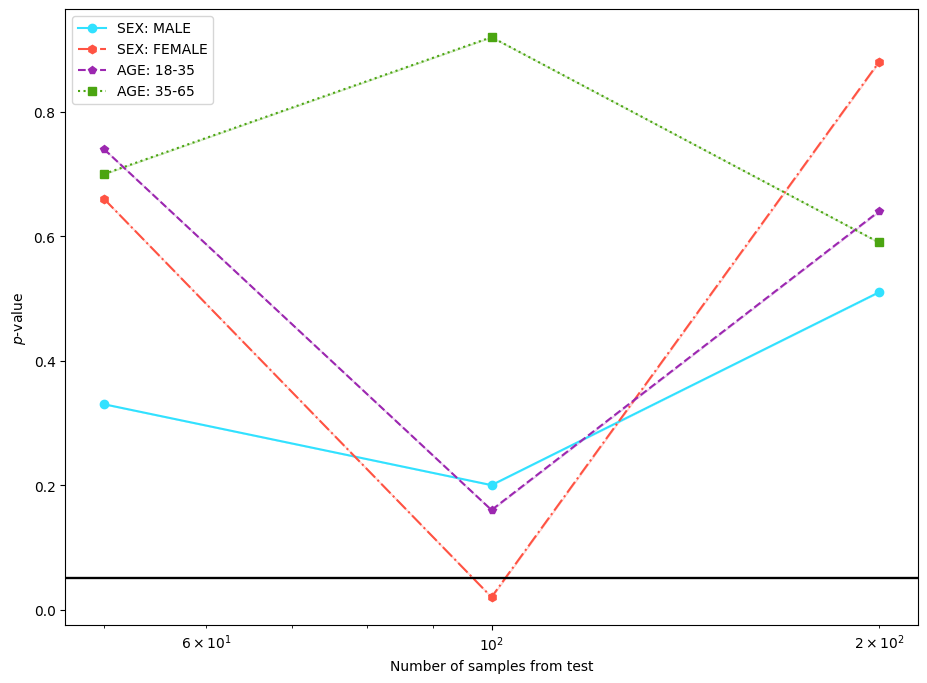

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.87 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.33 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.91 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.99 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.12 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.29 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.13 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.64 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.10 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.76 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.38 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.89 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.81 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.34 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.10 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.53 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.38 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.73 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.64 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.54 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.13 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.96 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.44 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.43 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.05 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.63 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.17 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.00 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.45 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.67 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.95 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.11 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.03 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.24 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.35 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.27 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.94 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.11 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.23 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.42 examples/s]

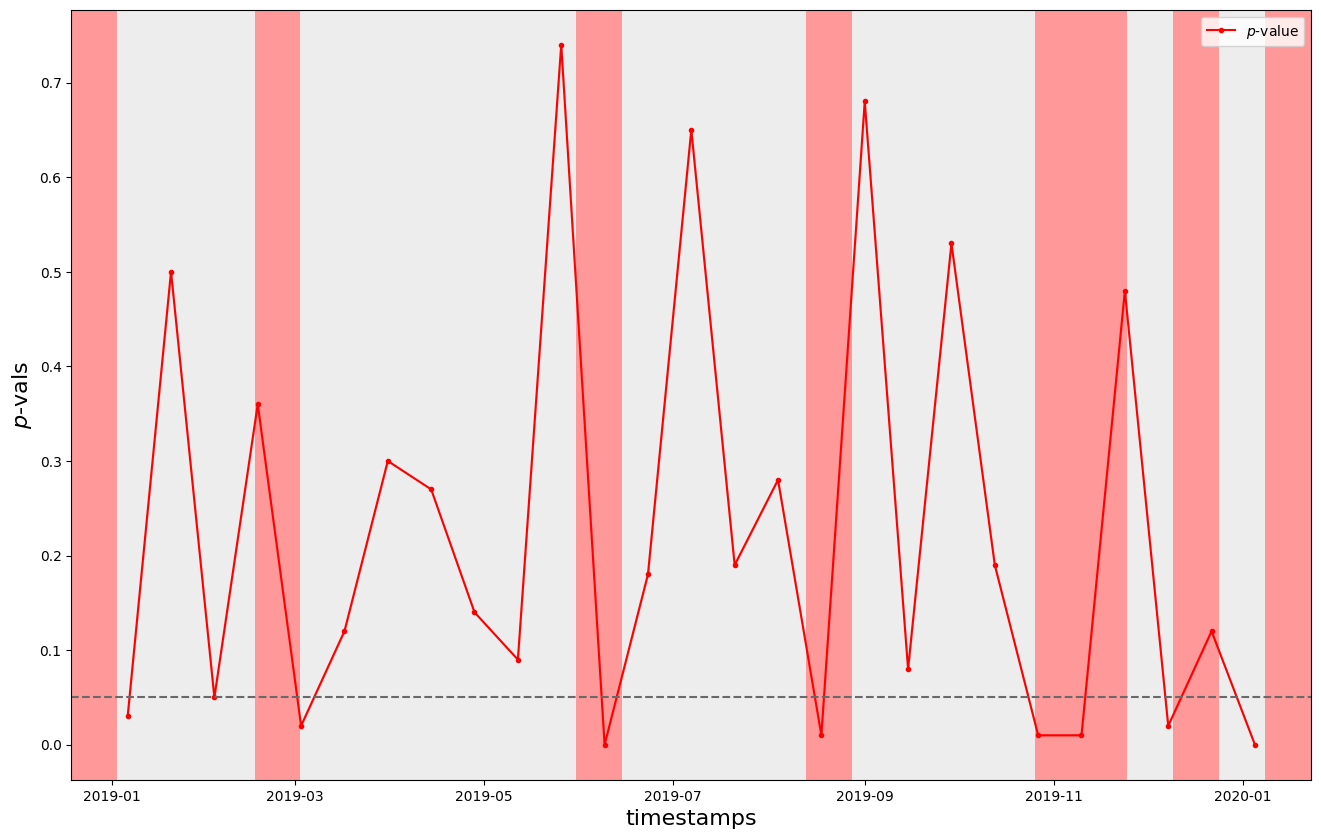

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)